In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import MobileNet_V3_Large_Weights
from torchinfo import summary

In [2]:
data_dir = "/home/abir/Repos/real-time-face-mask-detection/data"

In [3]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor()
    ]),

    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=image_transforms["train"])
val_data = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=image_transforms["val"])
test_data = datasets.ImageFolder(os.path.join(data_dir, "Test"), transform=image_transforms["val"])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['WithMask', 'WithoutMask']


In [4]:
print(f"Size of the traing data is {len(train_data)}")
print(f"Size of the validation data is {len(val_data)}")
print(f"Size of the testing data is {len(test_data)}")

Size of the traing data is 17450
Size of the validation data is 800
Size of the testing data is 992


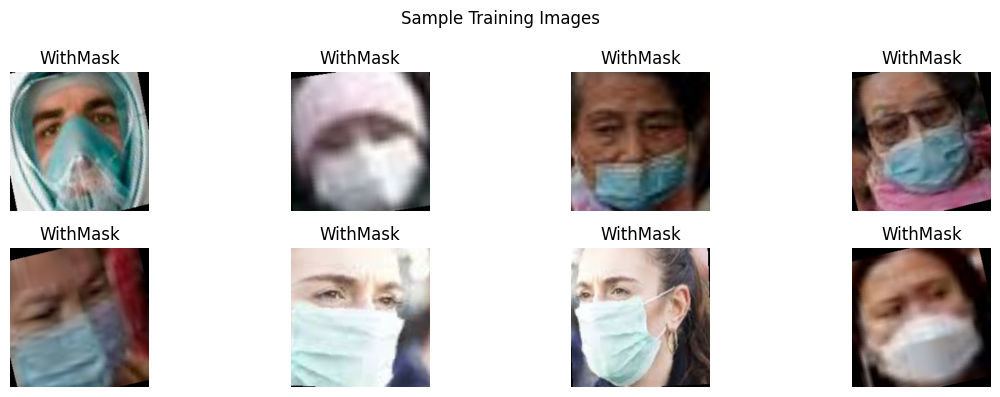

In [5]:
def show_samples(dataset, title):
    fig, axes = plt.subplots(2, 4, figsize=(12, 4))
    for i, ax in enumerate(axes.flatten()):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_data, "Sample Training Images")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# import model
mobilenet = models.mobilenet_v3_large( weights='MobileNet_V3_Large_Weights.DEFAULT').to(device)

In [8]:
# print summary using torchinfo
summary(model=mobilenet, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

In [9]:
# Freeze all base layers in the "features" section of the model by setting requires_grad=False
for param in mobilenet.features.parameters():
    param.requires_grad = False

In [10]:
# Recreate the classifier layer for our problem
mobilenet.classifier = torch.nn.Sequential(
    nn.Linear(in_features=960, out_features=1280),
    nn.Hardswish(), 
    nn.Dropout(p=0.2), 
    nn.Linear(in_features=1280, out_features=len(class_names)).to(device)
)

In [11]:
summary(model=mobilenet, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 